In [ ]:
%%capture
!pip install datasets==1.11.0
!pip install transformers==4.9.1
!pip install soundfile
!pip install jiwer

#Adjusting a Hugginface ASR model - facebook/wav2vec2-large-960h-lv60-self on custom dataset with samples of speech (Scott Morrison MP only at this stage)

The ASR step will generate a continuous data stream from any (or ALL!) parliaments in Australia.

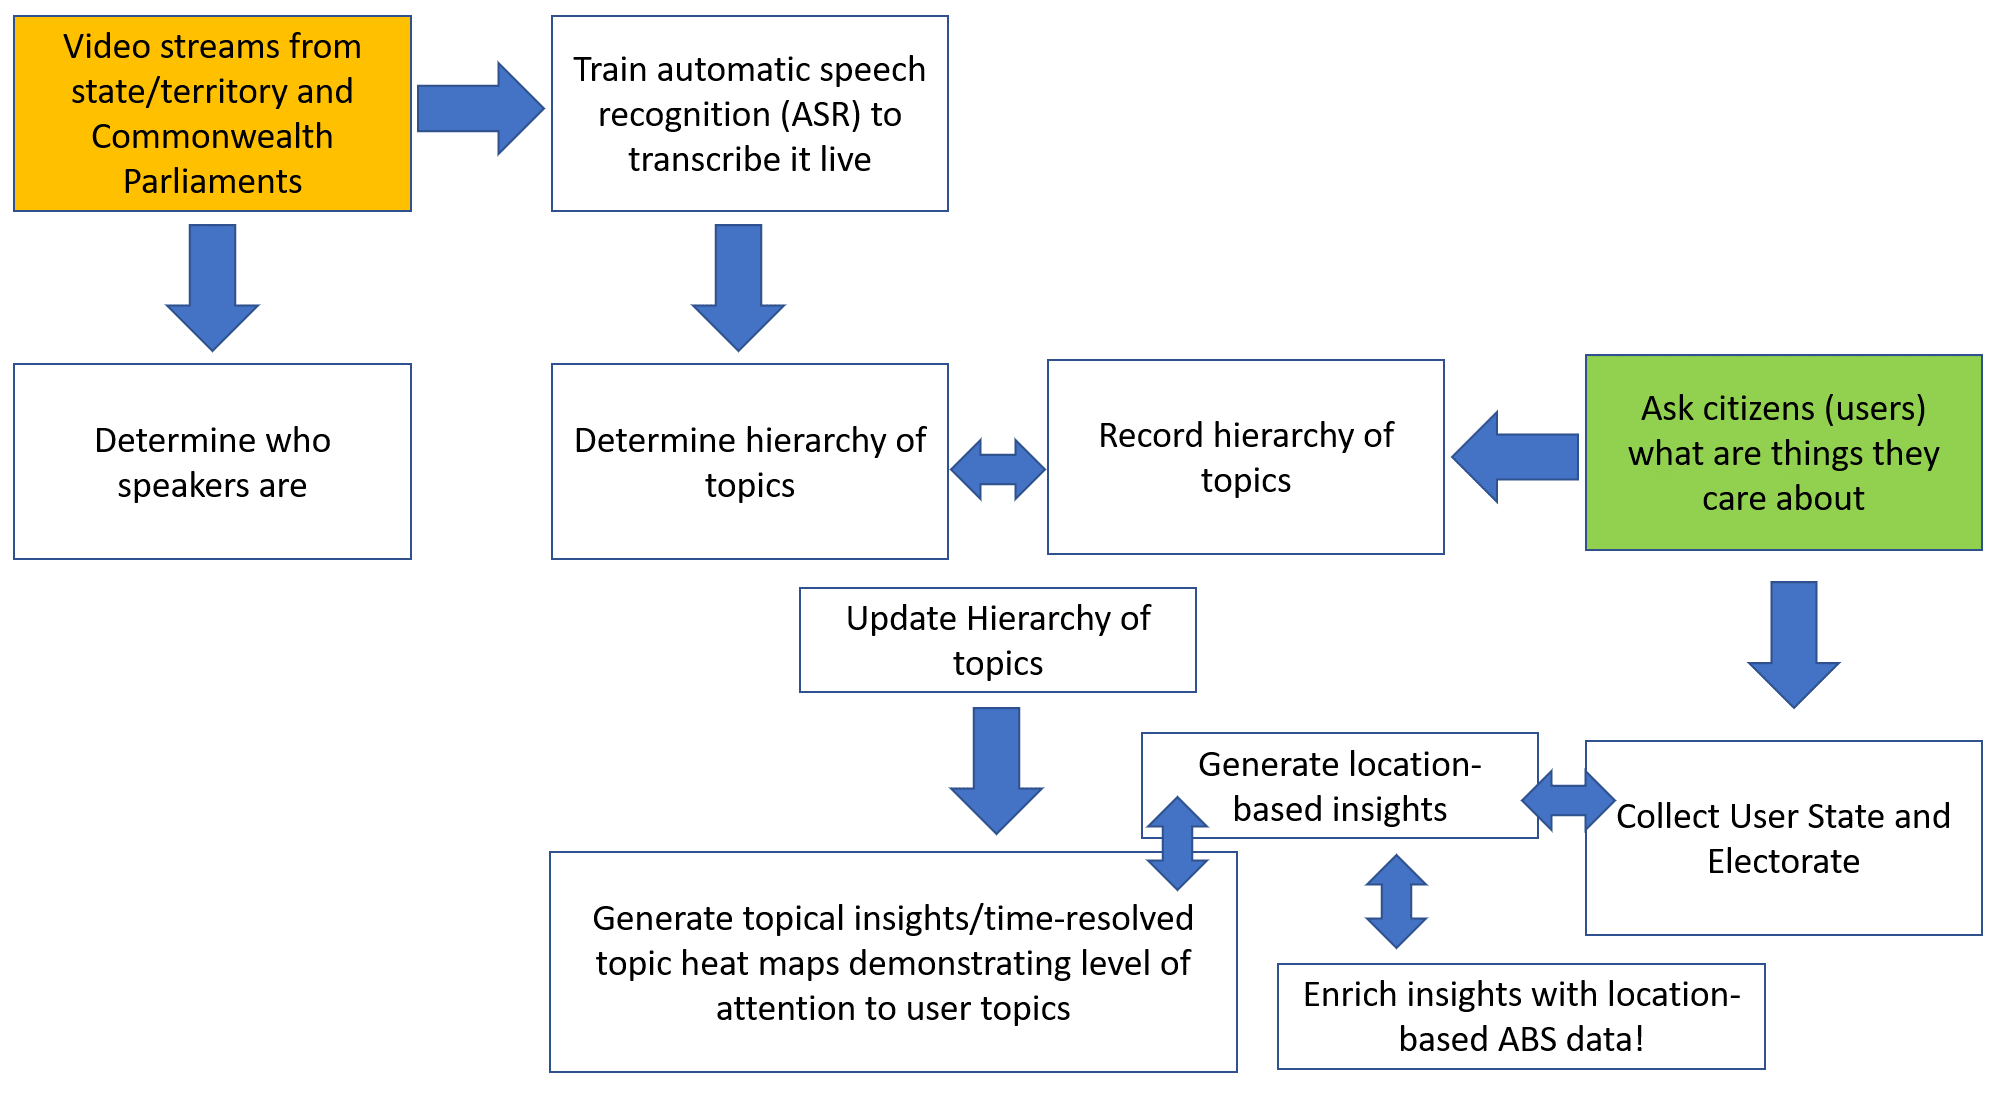



#now, let's load our custom dataset, check its samples, test Word Error Rate  (WER) of the starting model, train the model, and re-check the WER score!

In [ ]:
# check if we are lucky to get a good frame buffer GPU allocated
!nvidia-smi

Sat Aug 21 1:46:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
try:
  os.chdir('gdrive/MyDrive')
except:
  pass
os.listdir()

['Colab Notebooks',
 'cache',
 'original-facebook-wav2vec2-large-960h-lv60-self',
 'cap_aph_asr',
 'wav2vec2-aph-cap']

In [ ]:
from datasets import load_dataset, load_metric
timit = load_dataset("cap_aph_asr", cache_dir='cache') 

Reusing dataset aph_asr (cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0)


In [ ]:
timit = timit.remove_columns(["id"])
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'text'],
        num_rows: 481
    })
    test: Dataset({
        features: ['file', 'text'],
        num_rows: 174
    })
})

In [ ]:

from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))
    
    
show_random_elements(timit["train"].remove_columns(["file"]), num_examples=20)


,text
0,SO THERE WILL BE FURTHER WORK DONE AH PREPARING FOR THOSE PHASES AND HOW RAPID ANTIGEN TESTING CAN BE BETTER USED IN THOSE PHASES
1,FOR THOSE WHO ARE BEING TRANSFERRED BACK TO AUSTRALIA TO BE QUARANTINED AN APPROPRIATE
2,THE LOCAL COMMUNITY HERE WE ARE REACHING OUT TO THE U N H C R AND
3,OVER THE LAST FOUR MONTHS
4,WHEN IT COMES TO THE IMPACTS OF BORDER CONTROLS AND WHAT'S HAPPENING AND A VERY GOOD EXAMPLE IS WHAT'S HAPPENING WITH A A FLIGHT NETWORK SUBSIDIES AVIATION NETWO
5,THEN LET'S LIFT THEM UP AGAIN BECAUSE WE ARE GOING TO GET THROUGH THIS AND WE'RE GOING TO BEAT THIS
6,I HAVE PUT MORE WOMEN IN MY CABINET THAN ANY OTHER PRIME MINISTER EVER HAS BEFORE
7,UPTICKING IN THEIR BUILDING AND CONSTRUCTION SECTORS
8,PARTICULARLY THOSE WHO ARE AT HOME AND YOU HEAR THE NEWS EACH DAY
9,AND DEAL WITH THE FIGHT AGAINST THE VIRUS EACH AND EVERY DAY WITH YOUR KEY WEAPONS BEING TESTING


In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]) + " "
    return batch
timit = timit.map(remove_special_characters)

show_random_elements(timit["train"].remove_columns(["file"]))

Loading cached processed dataset at cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0/cache-6da7a5717dab2dd1.arrow
Loading cached processed dataset at cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0/cache-29a21aea13f0d939.arrow


,text
0,WE'VE GONE FROM FIVE POINT ONE PER CENT TO OVER FIFTIES
1,NOW FORGIVE ME THE INDULGENCE
2,I WANT YOU TO KNOW THAT WE WILL CONTINUE TO DO
3,THAN MORE THAN A BILLION DOLLARS
4,A THE ISSUES WHICH WE ADDRESSED TODAY A COMMENCED WITH A ECONOMY DOCTOR LOWE AND DOCTOR KENNEDY JOINED THE NATIONAL CABINET
5,HEARING TODAY FROM THE WESTERN AUSTRALIAN AND TASMANIAN PREMIERS
6,THAT'S NOT OKAY THAT'S NOT ACCEPTABLE
7,I ACKNOWLEDGE THAT MANY AUSTRALIANS ESPECIALLY WOMEN
8,THE BIGGEST CHALLENGE WHICH IS SHARED BY OUR GOVERNMENT IS UNEMPLOYMENT
9,HOW DOES THE TRACING CAPACITY


# We can create a new vocab from our dataset

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print("Type:", type(vocab_dict))
vocab_dict

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Type: <class 'dict'>


{' ': 26,
 "'": 24,
 'A': 27,
 'B': 10,
 'C': 20,
 'D': 8,
 'E': 14,
 'F': 12,
 'G': 18,
 'H': 25,
 'I': 5,
 'J': 11,
 'K': 23,
 'L': 0,
 'M': 16,
 'N': 17,
 'O': 21,
 'P': 3,
 'Q': 2,
 'R': 1,
 'S': 6,
 'T': 22,
 'U': 15,
 'V': 19,
 'W': 13,
 'X': 7,
 'Y': 4,
 'Z': 9}

# However, let's check vocab of the existing model we are planning to fine-tune

In [ ]:
import json
  
# Opening JSON exising 
with open('./original-facebook-wav2vec2-large-960h-lv60-self/vocab.json') as json_file:
    data = json.load(json_file)
  
    # Print the type of data variable
    print("Type:", type(data))
data

Type: <class 'dict'>


{"'": 27,
 '</s>': 2,
 '<pad>': 0,
 '<s>': 1,
 '<unk>': 3,
 'A': 7,
 'B': 24,
 'C': 19,
 'D': 14,
 'E': 5,
 'F': 20,
 'G': 21,
 'H': 11,
 'I': 10,
 'J': 29,
 'K': 26,
 'L': 15,
 'M': 17,
 'N': 9,
 'O': 8,
 'P': 23,
 'Q': 30,
 'R': 13,
 'S': 12,
 'T': 6,
 'U': 16,
 'V': 25,
 'W': 18,
 'X': 28,
 'Y': 22,
 'Z': 31,
 '|': 4}

# as they overlap, let's inherit the map of the existing model to optimise fine-tuning

In addition to vocab we will recycle feature extractor and processor from the parent model

In [ ]:
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))

#Create Wav2Vec2 Feature Extractor
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))

In [ ]:
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
processor.save_pretrained("./wav2vec2-aph-cap")

In [ ]:
import soundfile as sf
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = sf.read(batch["file"])
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["text"]
    return batch
# data, samplerate = sf.read(timit['train'][0]['file'])
timit = timit.map(speech_file_to_array_fn, remove_columns=timit.column_names["train"], num_proc=1)

Loading cached processed dataset at cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0/cache-c2206646c146beef.arrow
Loading cached processed dataset at cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0/cache-4116d4dc0018db1c.arrow


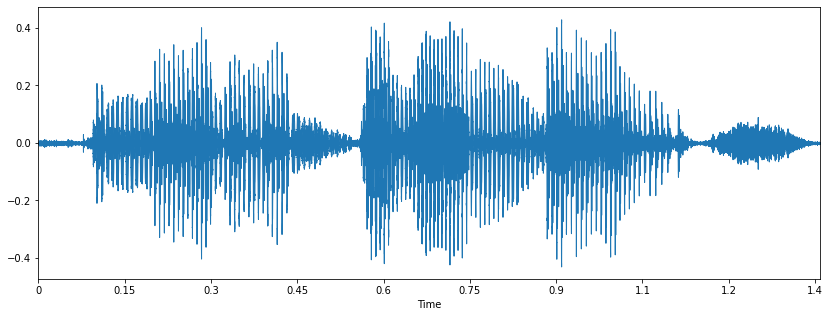

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(timit["train"]))
import matplotlib.pyplot as plt
import librosa.display
import librosa as lb

plt.figure(figsize=(14, 5))
librosa.display.waveplot(np.asarray(timit["train"][rand_int]["speech"]), sr=16000)
ipd.Audio(data=np.asarray(timit["train"][rand_int]["speech"]), autoplay=True, rate=16000)

In [ ]:
rand_int = random.randint(0, len(timit["train"]))

print("Target text:", timit["train"][rand_int]["target_text"])
print("Input array shape:", np.asarray(timit["train"][rand_int]["speech"]).shape)
print("Sampling rate:", timit["train"][rand_int]["sampling_rate"])

Target text: ON THAT DAY IN NINETEEN SIXTY SIX SEVENTEEN AUSTRALIANS WERE KILLED IN ACTION 
Input array shape: (62496,)
Sampling rate: 16000


In [ ]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."
    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

timit_prepared = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], batch_size=8, num_proc=1, batched=True)

Loading cached processed dataset at cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0/cache-40214c664360eadd.arrow
Loading cached processed dataset at cache/aph_asr/clean/1.0.0/f1104dee43a1c0a3093247510ebf25afae3d6476617f985faebc4b3d897ba1f0/cache-d5dd47b968e66516.arrow


# Let's evaluate our out-of-the-box parent model


In [ ]:
wer_metric = load_metric("wer")
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2ForCTC
model = Wav2Vec2ForCTC.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))
processor = Wav2Vec2Processor.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at original-facebook-wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
if torch.cuda.is_available():
  dev_to_use = "cuda"
else:
  dev_to_use = "cpu"
def map_to_result(batch):

  model.to(dev_to_use) # model.to("cuda")
  input_values = processor(
      batch["speech"], 
      sampling_rate=batch["sampling_rate"], 
      return_tensors="pt"
  ).input_values.to(dev_to_use)  # ).input_values.to("cuda")
  with torch.no_grad():
    logits = model(input_values).logits
  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  return batch

results = timit["test"].map(map_to_result)
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["target_text"])))



  0%|          | 0/174 [00:00<?, ?ex/s]

Test WER: 0.097


This is a very good word error rate for an out-of-the-box model. Let's see actual examples...

In [ ]:
#select sample number and subset below:
samp_nr = 62
subset = "test" # train
###
real_transcript = timit[subset][samp_nr]["target_text"]

print('True transcription: ', real_transcript)
ipd.Audio(data=np.asarray(timit[subset][samp_nr]["speech"]), autoplay=True, rate=16000)


True transcription:  AND WE WANT TO BE ABLE TO CONTINUE TO ACHIEVE THAT AS BEST AS WE POSSIBLY CAN AS WE CONTINUE THROUGH THE SUPPRESSION PHASE AND THAT'S WHY THERE AREN'T ANY SHORT CUTS 


In [ ]:
input_values = processor(timit[subset][samp_nr]["speech"], sampling_rate=16000, return_tensors="pt", padding="longest").input_values  # Batch size 1
model = Wav2Vec2ForCTC.from_pretrained(os.path.relpath('./original-facebook-wav2vec2-large-960h-lv60-self'))
# retrieve logits
logits = model(input_values).logits
# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
[transcription] = tokenizer.batch_decode(predicted_ids)
print('Predicted transcription: ', transcription)



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at original-facebook-wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted transcription:  AND WE WANT TO BE ABLE TO CONTINUE TO ACHIEVE THAT AS BEST AS WE POSSIBLY CAN AS WE CONTINUE THROUGH THIS SUPPRESSION PHASE AND THAT'S WHY THERE AREN'T ANY SHORT CUTS


# We can try to improve WER with fine-tuning on our dataset

In [ ]:
torch.cuda.empty_cache()
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:

# re-initiallise our model and freeze feature extractor

model = Wav2Vec2ForCTC.from_pretrained(
    './original-facebook-wav2vec2-large-960h-lv60-self',
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,    
)
model.freeze_feature_extractor()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ./original-facebook-wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./wav2vec2-aph-cap",
  group_by_length=True,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=150,
  fp16=True,
  save_steps=1500,
  eval_steps=1500,
  logging_steps=1500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit_prepared["train"],
    eval_dataset=timit_prepared["test"],
    tokenizer=processor.feature_extractor,
)


Using amp fp16 backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 481
  Num Epochs = 150
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4650
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Step,Training Loss,Validation Loss,Wer
1500,0.234900,0.165100,0.071575
3000,0.053800,0.189525,0.073288
4500,0.033200,0.198072,0.072945


/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1310: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
***** Running Evaluation *****
  Num examples = 174
  Batch size = 8
Saving model checkpoint to ./wav2vec2-aph-cap/checkpoint-1500
Configuration saved in ./wav2vec2-aph-cap/checkpoint-1500/config.json
Model weights saved in ./wav2vec2-aph-cap/checkpoint-1500/pytorch_model.bin
Configuration saved in ./wav2vec2-aph-cap/checkpoint-1500/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1310: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error ou

TrainOutput(global_step=4650, training_loss=0.10469669383059266, metrics={'train_runtime': 10553.6825, 'train_samples_per_second': 6.836, 'train_steps_per_second': 0.441, 'total_flos': 1.17450829050849e+19, 'train_loss': 0.10469669383059266, 'epoch': 150.0})

# Now we can re-evaluate the model and compare the two WER scores
ideally, this needs to be done on a test dataset not used in the training process, but we have to take a shortcut here due to scarcity of trainig data...

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("./wav2vec2-aph-cap") 
model = Wav2Vec2ForCTC.from_pretrained("./wav2vec2-aph-cap/checkpoint-4500")

results = timit["test"].map(map_to_result)
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["target_text"])))

loading feature extractor configuration file ./wav2vec2-aph-cap/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

Didn't find file ./wav2vec2-aph-cap/added_tokens.json. We won't load it.
Didn't find file ./wav2vec2-aph-cap/tokenizer.json. We won't load it.
loading file ./wav2vec2-aph-cap/vocab.json
loading file ./wav2vec2-aph-cap/tokenizer_config.json
loading file None
loading file ./wav2vec2-aph-cap/special_tokens_map.json
loading file None
loading configuration file ./wav2vec2-aph-cap/checkpoint-4500/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "./original-facebook-wav2vec2-large-960h-lv60-self",
  "activation_dropout": 0.1,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_toke

  0%|          | 0/174 [00:00<?, ?ex/s]

Test WER: 0.073


In [ ]:
results = timit["train"].map(map_to_result)
print("Train WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["target_text"])))

  0%|          | 0/481 [00:00<?, ?ex/s]

Test WER: 0.001
